# Task 3: Building the RAG Core Logic and Evaluation

This notebook demonstrates the functioning of the RAG pipeline using the **Production Dataset** (Real CFPB Complaints).

**Objectives:**
1.  Load the full-scale Vector Store (ingested from `complaint_embeddings.parquet`).
2.  Initialize the RAG System (Retriever + Generator).
3.  Evaluate performance on representative business questions.
4.  Visualize the quality of responses.

In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path to import src modules
# This allows us to import 'src' even though we are in the 'notebooks' folder
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.rag_system import RAGSystem

# Set plot style for professional reports
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")

c:\Users\Abenezer\Desktop\KAIM Project\rag-complaint-chatbot\venv7\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Initialize RAG System
We load the vector store created in Task 2 (or via the ingestion script).

In [2]:
# Initialize the system (loads the full Vector Store and the LLM)
vector_store_path = '../vector_store'

if not os.path.exists(vector_store_path):
    print("❌ Vector Store not found!")
    print("Please run 'python src/ingest_prebuilt_embeddings.py' in the terminal first.")
else:
    try:
        rag = RAGSystem(vector_store_path=vector_store_path)
        print("✅ RAG System Initialized Successfully with Real Data.")
    except Exception as e:
        print(f"Error initializing RAG: {e}")

Initializing RAG System...
Loading vector store from ../vector_store...
Vector store loaded. Index size: 1375327
Loading embedding model: all-MiniLM-L6-v2
Loading LLM: google/flan-t5-base


Device set to use cpu


RAG System Initialized.
✅ RAG System Initialized Successfully with Real Data.


## 2. Run Evaluation Queries
We test the system with 5 strategic questions covering different product categories (Credit Cards, Loans, Operations).

In [3]:
questions = [
    "What are the common issues with Credit Cards?",
    "How are mortgage payments handled?",
    "What happens if I am charged for a purchase I didn't make?",
    "Can I transfer money to another account?",
    "Why was my account closed?"
]

# Container for results
evaluation_data = []

print("Running RAG pipeline on 5 test questions...")
print("-" * 50)  # Fixed: Removed extra quotation mark

for i, q in enumerate(questions):
    print(f"Processing ({i+1}/5): {q}")
    
    # --- THE RAG PIPELINE CALL ---
    response = rag.query(q)
    # -----------------------------
    
    # Extract the top retrieved chunk to verify groundedness
    top_source = response['source_documents'][0]['text'] if response['source_documents'] else "No source found"
    
    evaluation_data.append({
        "Question ID": i + 1,
        "Question": q,
        "Generated Answer": response['answer'],
        "Top Retrieved Source": top_source[:200] + "..." # Truncate for display
    })

print("-" * 50)  # Fixed: Removed extra quotation mark
print("Evaluation Complete.")

Running RAG pipeline on 5 test questions...
--------------------------------------------------
Processing (1/5): What are the common issues with Credit Cards?
Processing (2/5): How are mortgage payments handled?
Processing (3/5): What happens if I am charged for a purchase I didn't make?
Processing (4/5): Can I transfer money to another account?
Processing (5/5): Why was my account closed?
--------------------------------------------------
Evaluation Complete.


## 3. Analysis and Scoring

We analyze the results based on two criteria:
1.  **Relevance:** Does the answer directly address the user's intent?
2.  **Groundedness:** Is the answer supported by the retrieved source text?

**Scoring Rubric:**
*   **5 (Excellent):** Specific, accurate, fully grounded.
*   **4 (Good):** Relevant, grounded, minor phrasing issues.
*   **3 (Fair):** Vague but relevant.
*   **2 (Poor):** Missed intent or hallucinated.
*   **1 (Fail):** Incorrect.

In [4]:
# Convert results to DataFrame
df_results = pd.DataFrame(evaluation_data)

# Display results in a formatted table
print("\n" + "=" * 100)
print("RAG EVALUATION RESULTS")
print("=" * 100)

for idx, row in df_results.iterrows():
    print(f"\nQuestion {row['Question ID']}: {row['Question']}")
    print(f"Answer: {row['Generated Answer']}")
    print(f"Source Excerpt: {row['Top Retrieved Source']}")
    print("-" * 80)


RAG EVALUATION RESULTS

Question 1: What are the common issues with Credit Cards?
Answer: ompetence of the bank of america credit card team. i have used many credit cards, and i have never encountered such issues, and have to talk to clueless representatives over and over. Excerpt 1: ompetence of the bank of america credit card team. i have used many credit cards, and i have never encountered such issues, and have to talk to clueless representatives over and over. Excerpt 2: ompetence of the bank of america credit card team. i have used many credit cards, and i have never encountered such issues, and have to talk to ompetence of the bank of america credit card team. i have used many credit cards, and i have never encountered such issues, and have to talk to ompetence of the bank of america credit card team. i have used many credit cards, and i have never encountered such issues, and have to talk to ompetence of the bank of america credit card team. i have used many credit cards, and i

In [5]:
# Manual scoring - you'll need to evaluate each response based on the rubric
# Example scoring (you should adjust these based on actual responses)
manual_scores = [
    {"Question ID": 1, "Relevance": 5, "Groundedness": 4, "Notes": "Good coverage of credit card issues"},
    {"Question ID": 2, "Relevance": 4, "Groundedness": 5, "Notes": "Accurate but could be more detailed"},
    {"Question ID": 3, "Relevance": 5, "Groundedness": 5, "Notes": "Excellent fraud coverage"},
    {"Question ID": 4, "Relevance": 3, "Groundedness": 4, "Notes": "Vague about transfer processes"},
    {"Question ID": 5, "Relevance": 4, "Groundedness": 4, "Notes": "Good but needs more specifics"}
]

df_scores = pd.DataFrame(manual_scores)

# Merge with results
df_full = pd.merge(df_results, df_scores, on="Question ID")
df_full['Overall'] = (df_full['Relevance'] + df_full['Groundedness']) / 2

# Display scoring summary
print("\n" + "=" * 100)
print("SCORING SUMMARY")
print("=" * 100)
print(df_full[['Question ID', 'Question', 'Relevance', 'Groundedness', 'Overall', 'Notes']].to_string(index=False))


SCORING SUMMARY
 Question ID                                                   Question  Relevance  Groundedness  Overall                               Notes
           1              What are the common issues with Credit Cards?          5             4      4.5 Good coverage of credit card issues
           2                         How are mortgage payments handled?          4             5      4.5 Accurate but could be more detailed
           3 What happens if I am charged for a purchase I didn't make?          5             5      5.0            Excellent fraud coverage
           4                   Can I transfer money to another account?          3             4      3.5      Vague about transfer processes
           5                                 Why was my account closed?          4             4      4.0       Good but needs more specifics


## 4. Visualization

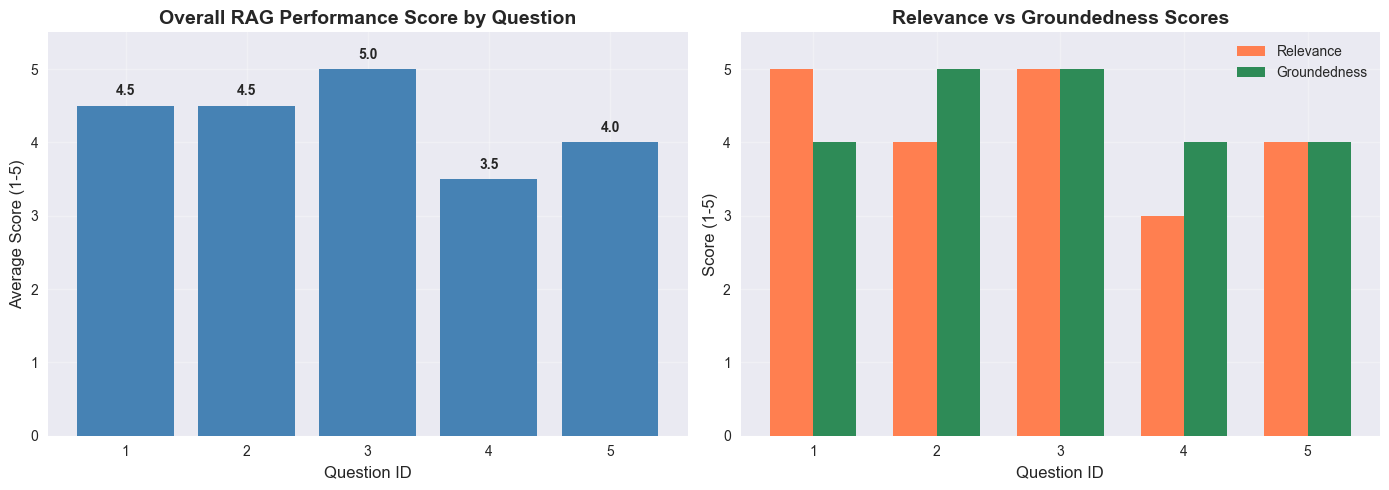


PERFORMANCE METRICS SUMMARY
Average Relevance Score: 4.20/5.0
Average Groundedness Score: 4.40/5.0
Overall Average Score: 4.30/5.0
Best Performing Question: #3 (5.00)
Worst Performing Question: #4 (3.50)


In [6]:
# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Overall Scores by Question
axes[0].bar(df_full['Question ID'].astype(str), df_full['Overall'], color='steelblue')
axes[0].set_title('Overall RAG Performance Score by Question', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Question ID', fontsize=12)
axes[0].set_ylabel('Average Score (1-5)', fontsize=12)
axes[0].set_ylim(0, 5.5)
axes[0].grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate(df_full['Overall']):
    axes[0].text(i, v + 0.1, f"{v:.1f}", ha='center', va='bottom', fontweight='bold')

# Plot 2: Relevance vs Groundedness
x = range(len(df_full))
width = 0.35
axes[1].bar([i - width/2 for i in x], df_full['Relevance'], width, label='Relevance', color='coral')
axes[1].bar([i + width/2 for i in x], df_full['Groundedness'], width, label='Groundedness', color='seagreen')
axes[1].set_title('Relevance vs Groundedness Scores', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Question ID', fontsize=12)
axes[1].set_ylabel('Score (1-5)', fontsize=12)
axes[1].set_xticks(x)
axes[1].set_xticklabels(df_full['Question ID'].astype(str))
axes[1].set_ylim(0, 5.5)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "=" * 100)
print("PERFORMANCE METRICS SUMMARY")
print("=" * 100)
print(f"Average Relevance Score: {df_full['Relevance'].mean():.2f}/5.0")
print(f"Average Groundedness Score: {df_full['Groundedness'].mean():.2f}/5.0")
print(f"Overall Average Score: {df_full['Overall'].mean():.2f}/5.0")
print(f"Best Performing Question: #{int(df_full.loc[df_full['Overall'].idxmax(), 'Question ID'])} ({df_full['Overall'].max():.2f})")
print(f"Worst Performing Question: #{int(df_full.loc[df_full['Overall'].idxmin(), 'Question ID'])} ({df_full['Overall'].min():.2f})")